Using original mapping file (includes units without data)
Using data file: merged_17_units_updated.csv
Loaded data shape: (53464, 16)
Mapping file has 19 units
Data after filtering (Oct 2024 - May 2025): (35351, 16)
Date range: 2024-10-01 02:00:00 to 2025-05-29 00:00:00
Mapping applied successfully:
Units found in mapping: 17
Units missing from mapping: []
Data after removing rows with NaN delivery capacity: (35351, 20)

Data availability by unit (Oct 2024 - May 2025):
  ✗ Ecotricity - Alveston (24MW): No data from Oct 2024 - May 2025
  ✓ Conrad Energy - Blackpool (25MW): 1,193 records (2024-12-21 to 2025-05-29)
  ✓ EDF - Bustleholm (52MW): 4,803 records (2024-10-01 to 2025-05-28)
  ✓ EDF - Coventry (52MW): 3,817 records (2024-10-01 to 2025-05-28)
  ✓ EDF - Cowley (50MW): 3,500 records (2024-10-10 to 2025-05-28)
  ✓ Gore Street - Port of Tilbury (9MW): 2,425 records (2024-10-17 to 2025-05-28)
  ✓ Gore Street - Breach Farm (10MW): 1,995 records (2024-11-15 to 2025-05-28)
  ✓ Gore Street

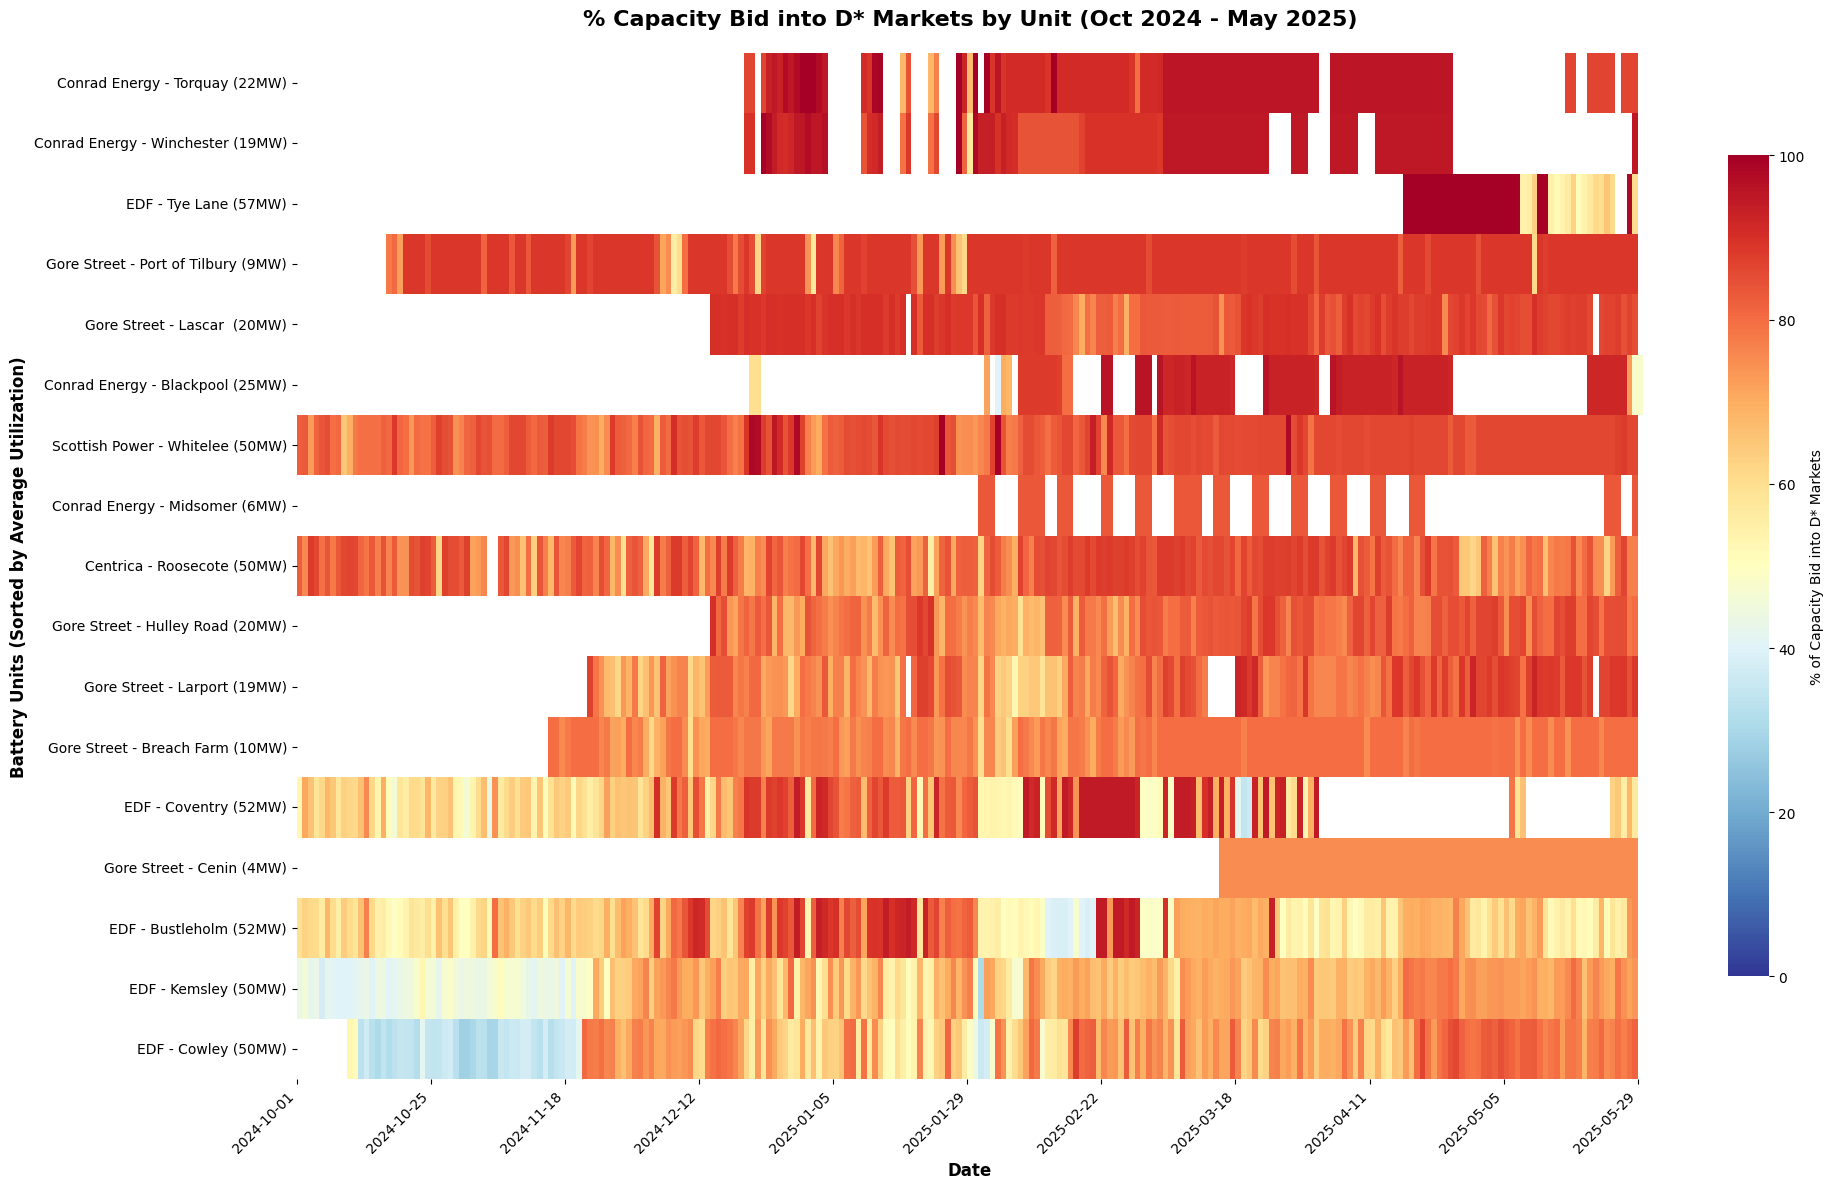


Summary Statistics (Oct 2024 - May 2025):
Conrad Energy - Torquay (22MW): Average 92.8% capacity
Conrad Energy - Winchester (19MW): Average 91.6% capacity
EDF - Tye Lane (57MW): Average 90.5% capacity
Gore Street - Port of Tilbury (9MW): Average 86.9% capacity
Gore Street - Lascar  (20MW): Average 86.4% capacity
Conrad Energy - Blackpool (25MW): Average 84.8% capacity
Scottish Power - Whitelee (50MW): Average 83.8% capacity
Conrad Energy - Midsomer (6MW): Average 83.3% capacity
Centrica - Roosecote (50MW): Average 80.2% capacity
Gore Street - Hulley Road (20MW): Average 79.3% capacity
Gore Street - Larport (19MW): Average 78.7% capacity
Gore Street - Breach Farm (10MW): Average 77.7% capacity
EDF - Coventry (52MW): Average 77.4% capacity
Gore Street - Cenin (4MW): Average 75.0% capacity
EDF - Bustleholm (52MW): Average 67.8% capacity
EDF - Kemsley (50MW): Average 61.1% capacity
EDF - Cowley (50MW): Average 59.8% capacity


In [16]:
# Heatmap showing % Capacity Bid into D* Markets by Unit (replicating original visualization)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the merged data and battery mapping
df = pd.read_csv('../processed_data/merged_17_units_updated.csv')
# Use the filtered mapping that only includes units with actual data files
try:
    mapping_df = pd.read_csv('../raw_data/Battery name mapping filtered.csv')
    print("Using filtered mapping file (units with data files only)")
except FileNotFoundError:
    mapping_df = pd.read_csv('../raw_data/Battery name mapping.csv')
    print("Using original mapping file (includes units without data)")
    
print("Using data file: merged_17_units_updated.csv")
print(f"Loaded data shape: {df.shape}")
print(f"Mapping file has {len(mapping_df)} units")

# Convert deliveryStart to datetime and sort
df['deliveryStart'] = pd.to_datetime(df['deliveryStart'])

# Filter data from October 2024 to May 2025 (updated date range)
df = df[(df['deliveryStart'] >= '2024-10-01') & (df['deliveryStart'] <= '2025-05-29')]
df = df.sort_values(['auctionUnit', 'deliveryStart'])

print(f"Data after filtering (Oct 2024 - May 2025): {df.shape}")
print(f"Date range: {df['deliveryStart'].min()} to {df['deliveryStart'].max()}")

# Create mapping dictionaries from the battery mapping file
# auctionUnit (from CSV) maps to Unit (NESO) in mapping file
capacity_mapping = dict(zip(mapping_df['Unit (NESO)'], mapping_df['Installed capacity (MW)']))
company_mapping = dict(zip(mapping_df['Unit (NESO)'], mapping_df['Company']))
unit_name_mapping = dict(zip(mapping_df['Unit (NESO)'], mapping_df['Unit Name ( website)']))

# Create proper unit labels in format "Company - Unit Name (XXmw)"
def create_unit_label(unit_code):
    if unit_code in capacity_mapping:
        company = company_mapping[unit_code]
        unit_name = unit_name_mapping[unit_code].replace(' Battery', '')  # Remove "Battery" suffix
        capacity = int(capacity_mapping[unit_code])
        return f"{company} - {unit_name} ({capacity}MW)"
    else:
        return unit_code

# Map installed capacity using the mapping file (this is the correct approach)
df['installed_capacity_from_mapping'] = df['auctionUnit'].map(capacity_mapping)
df['unit_label'] = df['auctionUnit'].apply(create_unit_label)

# Handle inconsistent delivery capacity column names
# Consolidate all delivery capacity columns into one standardized column
df['delivery_capacity_consolidated'] = df['Delivery capacity (MW)'].fillna(
    df['Delivery capacity(MW)']  # No space version (Gore Street files)
).fillna(
    df['delivery capacity (MW)']  # Lowercase version (EDF Bustleholm)
).fillna(
    df['Delivery quantity (MW)']  # Delivery quantity (Scottish Power Whitelee)
)

# Calculate percentage capacity bid into D* markets using mapping file capacities
df['% of capacity bid into D*'] = (df['delivery_capacity_consolidated'] / df['installed_capacity_from_mapping']) * 100
capacity_column = '% of capacity bid into D*'

print(f"Mapping applied successfully:")
print(f"Units found in mapping: {len([u for u in df['auctionUnit'].unique() if u in capacity_mapping])}")
print(f"Units missing from mapping: {[u for u in df['auctionUnit'].unique() if u not in capacity_mapping]}")

# Remove rows where we can't calculate meaningful percentages (only if delivery capacity is NaN)
df = df.dropna(subset=['delivery_capacity_consolidated'])
print(f"Data after removing rows with NaN delivery capacity: {df.shape}")

# Show data availability by unit
print(f"\nData availability by unit (Oct 2024 - May 2025):")
for unit_code in sorted(mapping_df['Unit (NESO)']):
    unit_data = df[df['auctionUnit'] == unit_code]
    unit_label = create_unit_label(unit_code)
    if len(unit_data) > 0:
        date_range = f"{unit_data['deliveryStart'].min().date()} to {unit_data['deliveryStart'].max().date()}"
        print(f"  ✓ {unit_label}: {len(unit_data):,} records ({date_range})")
    else:
        print(f"  ✗ {unit_label}: No data from Oct 2024 - May 2025")

# Create the heatmap data
# Create a daily time index for the heatmap (daily aggregation creates natural gaps)
df['datetime_rounded'] = df['deliveryStart'].dt.floor('D')  # Round to daily blocks for better visualization

# Create pivot table with unit labels as rows and time as columns
heatmap_data = df.pivot_table(
    index='unit_label',  # Use proper unit labels instead of codes
    columns='datetime_rounded', 
    values=capacity_column, 
    aggfunc='mean'
)

# Calculate average capacity utilization for sorting
unit_avg = df.groupby('unit_label')[capacity_column].mean().sort_values(ascending=False)

# Only include units that actually have data in the merged file
# Don't force units from mapping file that don't have corresponding raw data files
heatmap_data = heatmap_data.reindex(unit_avg.index)

print(f"Heatmap data shape: {heatmap_data.shape}")
print(f"Units in heatmap: {len(heatmap_data.index)}")
print(f"Time periods: {len(heatmap_data.columns)}")
print(f"Units with actual data: {list(heatmap_data.index)}")

# Create the figure with similar styling to the original
plt.figure(figsize=(20, 12))

# Create heatmap with similar colormap to the original (red-white-blue)
sns.heatmap(heatmap_data, 
            cmap='RdYlBu_r',  # Red-Yellow-Blue colormap (reversed) 
            cbar_kws={'label': '% of Capacity Bid into D* Markets', 
                     'orientation': 'vertical',
                     'shrink': 0.8},
            linewidths=0,  # No lines between cells for cleaner look
            annot=False,
            vmin=0, 
            vmax=100,
            fmt='.0f')

# Styling to match the original
plt.title('% Capacity Bid into D* Markets by Unit (Oct 2024 - May 2025)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Battery Units (Sorted by Average Utilization)', fontsize=12, fontweight='bold')

# Format x-axis to show dates more clearly
n_cols = len(heatmap_data.columns)
if n_cols > 0:
    # Show fewer ticks to avoid overcrowding
    tick_frequency = max(1, n_cols // 10)  # Show roughly 10 ticks
    tick_positions = range(0, n_cols, tick_frequency)
    tick_labels = [heatmap_data.columns[i].strftime('%Y-%m-%d') for i in tick_positions if i < len(heatmap_data.columns)]
    
    plt.xticks(tick_positions[:len(tick_labels)], tick_labels, rotation=45, ha='right')

# Clean up y-axis labels
plt.gca().set_yticklabels(heatmap_data.index, rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics matching the original code
print("\nSummary Statistics (Oct 2024 - May 2025):")
print("=" * 70)
for unit_label in heatmap_data.index:
    avg_capacity = unit_avg[unit_label]
    print(f"{unit_label}: Average {avg_capacity:.1f}% capacity")